In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
GBQ_PROJECT_ID = '620265099307'

import datetime
import matplotlib.gridspec as gridspec
import seaborn as sns

import geopandas as gpd
from matplotlib import verbose
#verbose.level = 'helpful'      # one of silent, helpful, debug, debug-annoying

# Overall prescribing

## Import data

In [2]:
q = '''
SELECT
  p.practice,
  pct,
  p.month,
  SUM(items) AS items,
  ROUND(SUM(actual_cost),2) AS actual_cost,
  AVG(total_list_size) AS list_size,
  CAST(JSON_EXTRACT(MAX(star_pu), '$.oral_antibacterials_item') AS FLOAT64) AS star_pu_items,
  CAST(JSON_EXTRACT(MAX(star_pu), '$.oral_antibacterials_cost') AS FLOAT64) AS star_pu_cost
FROM
  ebmdatalab.alex.antibiotic_prescribing p
INNER JOIN
  ebmdatalab.hscic.practices prac
ON
  p.practice = prac.code
  AND prac.setting = 4
LEFT JOIN
  ebmdatalab.hscic.practice_statistics stat
ON
  p.practice = stat.practice
  AND p.month = stat.month
GROUP BY
  practice,
  pct,
  month
ORDER BY
  practice,
  month
'''

all_antibiotics = pd.read_gbq(q, GBQ_PROJECT_ID, verbose=False, dialect='standard')
all_antibiotics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 691198 entries, 0 to 691197
Data columns (total 8 columns):
practice         691198 non-null object
pct              691198 non-null object
month            691198 non-null datetime64[ns]
items            691198 non-null int32
actual_cost      691198 non-null float64
list_size        463621 non-null float64
star_pu_items    463621 non-null float64
star_pu_cost     463621 non-null float64
dtypes: datetime64[ns](1), float64(4), int32(1), object(2)
memory usage: 39.6+ MB


In [3]:
all_antibiotics.head()

,practice,pct,month,items,actual_cost,list_size,star_pu_items,star_pu_cost
0,P92637,02H,2014-01-01,150,586.01,2765.0,1452.579235,5993.087876
1,P92637,02H,2014-02-01,141,921.28,2765.0,1452.579235,5993.087876
2,P92637,02H,2014-03-01,133,915.56,2765.0,1452.579235,5993.087876
3,P92637,02H,2014-04-01,117,443.24,2749.0,1448.921276,5978.067733
4,P92637,02H,2014-05-01,150,1328.38,2749.0,1448.921276,5978.067733


### Calculate percentiles

In [4]:
pc = all_antibiotics.copy()
pc['Items per STAR-PU'] = pc['items'] / pc.star_pu_items
pc['Cost per STAR-PU'] = pc.actual_cost / pc.star_pu_cost

x = np.arange(0.1, 1, 0.1)
pc = pc.groupby('month').quantile(x)
pc = pc.reset_index().rename(columns={"level_1": 'percentile'})
pc.head(9)

,month,percentile,Cost per STAR-PU,Items per STAR-PU,actual_cost,items,list_size,star_pu_cost,star_pu_items
0,2010-08-01,0.1,NaN,NaN,353.740,88.0,NaN,NaN,NaN
1,2010-08-01,0.2,NaN,NaN,545.430,127.0,NaN,NaN,NaN
2,2010-08-01,0.3,NaN,NaN,739.195,164.0,NaN,NaN,NaN
3,2010-08-01,0.4,NaN,NaN,950.980,207.0,NaN,NaN,NaN
4,2010-08-01,0.5,NaN,NaN,1190.035,255.0,NaN,NaN,NaN
5,2010-08-01,0.6,NaN,NaN,1463.580,308.0,NaN,NaN,NaN
6,2010-08-01,0.7,NaN,NaN,1772.045,369.0,NaN,NaN,NaN
7,2010-08-01,0.8,NaN,NaN,2160.680,448.0,NaN,NaN,NaN
8,2010-08-01,0.9,NaN,NaN,2787.905,551.0,NaN,NaN,NaN


## Practice level plots

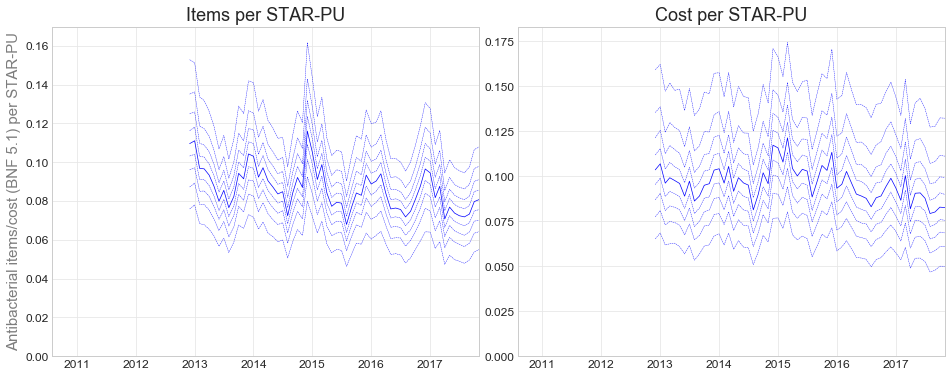

In [23]:
sns.set_style("whitegrid",{'grid.color': '.9'})
dfp = pc.sort_values(by=["month"])#,"drug"])
dfp['month'] = dfp['month'].astype(str)
# set format for dates:
dfp['dates'] = [datetime.datetime.strptime(date, '%Y-%m-%d').date() for date in dfp['month']]

# set sort order of drugs manually, and add grid refs to position each subplot:
s = [(0,'Items per STAR-PU',0,0), (1,'Cost per STAR-PU',0,1)]


fig = plt.figure(figsize=(16,20)) 
gs = gridspec.GridSpec(3,2)  # grid layout for subplots

# Plot each subplot using a loop
for i in s:
    ax = plt.subplot(gs[i[2], i[3]])  # position of subplot in grid using coordinates listed in s
    for decile in x:   # plot each decile line
        data = dfp.loc[(dfp['percentile']==decile)]#(dfp['drug']==i[1]) & 
        if decile == .5:
            ax.plot(data["dates"],data[i[1]],'b-',linewidth=0.7)
        else:
            #print (data)
            ax.plot(data["dates"],data[i[1]],'b--',linewidth=0.4)
    if  i[3]%2==0:    # set y axis title only for charts in leftmost column
        ax.set_ylabel('Antibacterial items/cost (BNF 5.1) per STAR-PU', size =15, alpha=0.6)
    ax.set_title(i[1],size = 18)
    ax.set_ylim([0, dfp[i[1]].max()*1.05])  # set ymax across all subplots as largest value across dataset
    ax.tick_params(labelsize=12)
    ax.set_xlim([dfp['dates'].min(), dfp['dates'].max()]) # set x axis range as full date range

plt.subplots_adjust(wspace = 0.09,hspace = 0.15)
plt.savefig('practice_deciles.png', format='png', dpi=300,bbox_inches='tight')
plt.show()

## CCG level

In [6]:
all_antibiotics_ccg = all_antibiotics.groupby(['pct','month'],as_index=False).sum()
pc_ccg = all_antibiotics_ccg
pc_ccg['Items per STAR-PU'] = pc_ccg['items'] / pc_ccg.star_pu_items
pc_ccg['Cost per STAR-PU'] = pc_ccg.actual_cost / pc_ccg.star_pu_cost
x = np.arange(0.1, 1, 0.1)
pc_ccg = pc_ccg.groupby('month').quantile(x)
pc_ccg = pc_ccg.reset_index().rename(columns={"level_1": 'percentile'})
pc_ccg.head(9)

,month,percentile,Cost per STAR-PU,Items per STAR-PU,actual_cost,items,list_size,star_pu_cost,star_pu_items
0,2010-08-01,0.1,NaN,NaN,1509.582,330.8,NaN,NaN,NaN
1,2010-08-01,0.2,NaN,NaN,26101.196,5825.0,NaN,NaN,NaN
2,2010-08-01,0.3,NaN,NaN,33492.082,7210.8,NaN,NaN,NaN
3,2010-08-01,0.4,NaN,NaN,39588.422,8239.4,NaN,NaN,NaN
4,2010-08-01,0.5,NaN,NaN,45496.770,9222.0,NaN,NaN,NaN
5,2010-08-01,0.6,NaN,NaN,50291.948,10472.2,NaN,NaN,NaN
6,2010-08-01,0.7,NaN,NaN,58276.420,11783.2,NaN,NaN,NaN
7,2010-08-01,0.8,NaN,NaN,66578.656,13897.4,NaN,NaN,NaN
8,2010-08-01,0.9,NaN,NaN,84900.716,17775.6,NaN,NaN,NaN


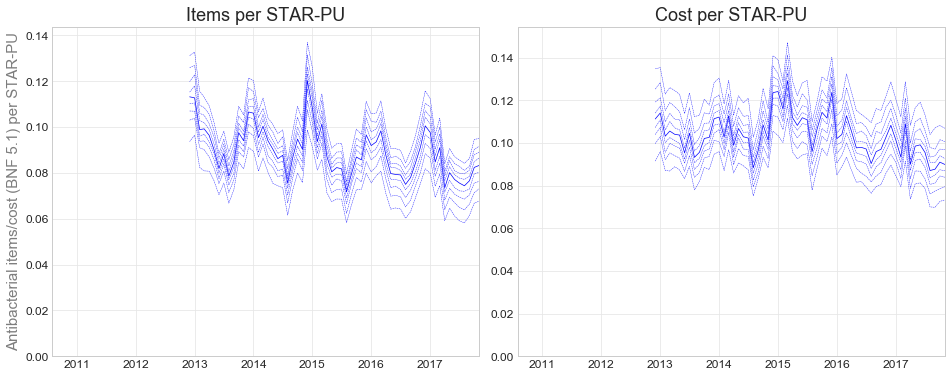

In [22]:
dfp = pc_ccg.sort_values(by=["month"])#,"drug"])
dfp['month'] = dfp['month'].astype(str)
# set format for dates:
dfp['dates'] = [datetime.datetime.strptime(date, '%Y-%m-%d').date() for date in dfp['month']]

# set sort order of drugs manually, and add grid refs to position each subplot:
s = [(0,'Items per STAR-PU',0,0), (1,'Cost per STAR-PU',0,1)]


fig = plt.figure(figsize=(16,20)) 
gs = gridspec.GridSpec(3,2)  # grid layout for subplots

# Plot each subplot using a loop
for i in s:
    ax = plt.subplot(gs[i[2], i[3]])  # position of subplot in grid using coordinates listed in s
    for decile in x:   # plot each decile line
        data = dfp.loc[(dfp['percentile']==decile)]#(dfp['drug']==i[1]) & 
        if decile == .5:
            ax.plot(data["dates"],data[i[1]],'b-',linewidth=0.7)
        else:
            #print (data)
            ax.plot(data["dates"],data[i[1]],'b--',linewidth=0.4)
    if  i[3]%2==0:    # set y axis title only for charts in leftmost column
        ax.set_ylabel('Antibacterial items/cost (BNF 5.1) per STAR-PU', size =15, alpha=0.6)
    ax.set_title(i[1],size = 18)
    ax.set_ylim([0, dfp[i[1]].max()*1.05])  # set ymax across all subplots as largest value across dataset
    ax.tick_params(labelsize=12)
    ax.set_xlim([dfp['dates'].min(), dfp['dates'].max()]) # set x axis range as full date range

plt.subplots_adjust(wspace = 0.09,hspace = 0.15)
plt.savefig('ccg_deciles.png', format='png', dpi=300,bbox_inches='tight')

plt.show()

# MAPS

In [20]:
#aggregate over last year
ccg_last_year = all_antibiotics_ccg.loc[all_antibiotics_ccg.month >='2016-11-01']
ccg_last_year = ccg_last_year.groupby('pct').sum()
ccg_last_year['Items per STAR-PU'] = ccg_last_year['items'] / ccg_last_year.star_pu_items
ccg_last_year['Cost per STAR-PU'] = ccg_last_year.actual_cost / ccg_last_year.star_pu_cost
ccg_last_year.head()

,items,actual_cost,list_size,star_pu_items,star_pu_cost,Items per STAR-PU,Cost per STAR-PU
pct,,,,,,,
00C,69636,339595.09,1401887.0,8.069967e+05,3.302717e+06,0.086290,0.102823
00D,216016,1057709.78,3779800.0,2.193138e+06,8.983378e+06,0.098496,0.117741
00J,176625,924024.94,3330694.0,1.910417e+06,7.847540e+06,0.092454,0.117747
00K,208481,1057331.16,3844297.0,2.182076e+06,8.956308e+06,0.095543,0.118054
00L,235508,1099682.44,4181161.0,2.503709e+06,1.023431e+07,0.094064,0.107451


In [19]:
# join to geographical data
map_data = ccg_last_year.reset_index()
names = pd.read_csv('ccg_for_map.csv')
map_data = map_data.merge(names[['code','name']],left_on="pct",right_on="code")
map_data['name'] = map_data['name'].str.upper()
map_data['name'] = map_data["name"].str.replace("&","AND")
map_data = map_data.set_index('name')
#map_data = map_data.round(0)
map_data.head() # 207 rows

,pct,items,actual_cost,list_size,star_pu_items,star_pu_cost,Items per STAR-PU,Cost per STAR-PU,code
name,,,,,,,,,
NHS DARLINGTON CCG,00C,69636,339595.09,1401887.0,8.069967e+05,3.302717e+06,0.086290,0.102823,00C
"NHS DURHAM DALES, EASINGTON AND SEDGEFIELD CCG",00D,216016,1057709.78,3779800.0,2.193138e+06,8.983378e+06,0.098496,0.117741,00D
NHS NORTH DURHAM CCG,00J,176625,924024.94,3330694.0,1.910417e+06,7.847540e+06,0.092454,0.117747,00J
NHS HARTLEPOOL AND STOCKTON-ON-TEES CCG,00K,208481,1057331.16,3844297.0,2.182076e+06,8.956308e+06,0.095543,0.118054,00K
NHS NORTHUMBERLAND CCG,00L,235508,1099682.44,4181161.0,2.503709e+06,1.023431e+07,0.094064,0.107451,00L


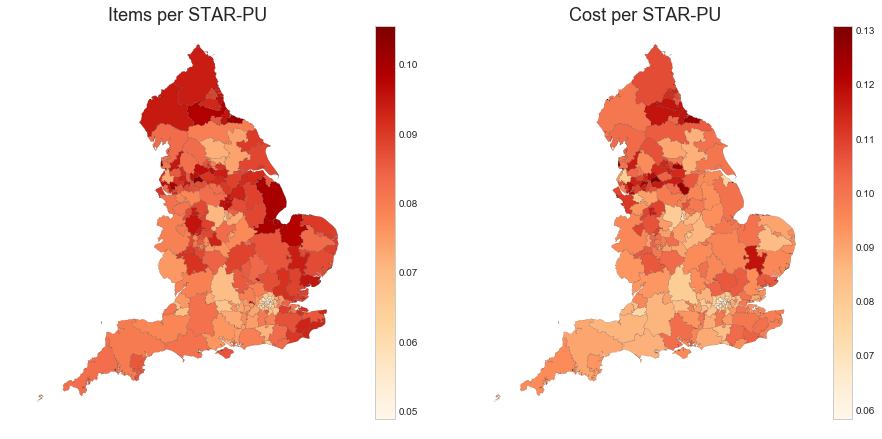

In [21]:
# from our API https://openprescribing.net/api/1.0/org_location/?org_type=ccg
ccgs = gpd.read_file('ccgs.json').set_index('name')

ccgs = ccgs[~ccgs['geometry'].isnull()]  # remove ones without geometry - these are federations rather than individual CCGs
gdf = ccgs.join(map_data)

# set sort order of measures manually, and add grid refs to position each subplot:
s = [(0,'Items per STAR-PU',0,0),      (1,'Cost per STAR-PU',0,1)]#, 
     #(2,'Percent high dose (by OME)',1,0),     (3,'Total cost (per 1000)',1,1)]

fig = plt.figure(figsize=(16,30))
gs = gridspec.GridSpec(4,2)  # grid layout for subplots

for i in s:
    ax = plt.subplot(gs[i[2], i[3]])  # position of subplot in grid using coordinates listed in s
    gdf.plot(ax=ax,column=i[1],  edgecolor='black', linewidth=0.1, legend=True, cmap='OrRd')
    ax.set_aspect(1.63)
    ax.set_title(i[1],size = 18)
    plt.axis('off')

plt.subplots_adjust(wspace = 0.05,hspace = 0.05)
plt.savefig('maps.png', format='png', dpi=300,bbox_inches='tight')

plt.show()